In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

23/06/07 22:27:24 WARN Utils: Your hostname, codespaces-3c66f5 resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
23/06/07 22:27:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/07 22:27:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
pandas_df = pd.read_csv("GlobalLandTemperaturesByMajorCity.csv")

In [4]:
df = spark.createDataFrame(pandas_df)
df.show(10)

+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1849-01-01|            26.704|                        1.435|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-02-01|            27.434|                        1.362|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-03-01|            28.101|                        1.612|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-04-01|             26.14|           1.3869999999999998|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-05-01|            25.427|                          1.2|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-06-01|            24.844|                        1.402|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1849-07-01|24.058000000000003|                        1.254|Abidjan|Côte

#### Задание 3.1 (1 балл)

В последующих заданиях будут учитываться данные начиная с 01.01.1950. Для этого создайте новый `DataFrame`, в котором удалены все строки до 01.01.1950. Используйте созданный DataFrame в последующих заданиях.  

In [5]:
import pyspark.sql.functions as f

In [29]:
trunc_df = df.filter("dt >= date'1950-01-01'")
print(trunc_df.count())
trunc_df=trunc_df.na.drop()
print(trunc_df.count())
trunc_df.show(10)

76500
76407
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|      Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+-------------+--------+---------+
|1950-01-01|26.773000000000003|                        0.239|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-02-01|            27.527|                        0.348|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-03-01|            28.344|                        0.431|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-04-01|             27.83|                        0.467|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-05-01|            26.896|                        0.248|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-06-01|            25.454|                        0.209|Abidjan|Côte D'Ivoire|   5.63N|    3.23W|
|1950-07-01|            24.878|                        0.403|

#### Задание 3.2 (2 балла)

Постройте график среднегодовых температур в городе Торонто.

+------------------+----+
|AverageTemperature|Year|
+------------------+----+
| 5.639583333333335|1950|
| 6.259083333333334|1951|
| 7.013416666666667|1952|
|7.5062500000000005|1953|
| 6.243083333333332|1954|
| 6.974750000000001|1955|
| 5.745750000000001|1956|
| 6.424916666666667|1957|
| 5.624333333333333|1958|
| 6.403750000000001|1959|
+------------------+----+
only showing top 10 rows



Text(0.5, 1.0, 'Toronto Average Temperature')

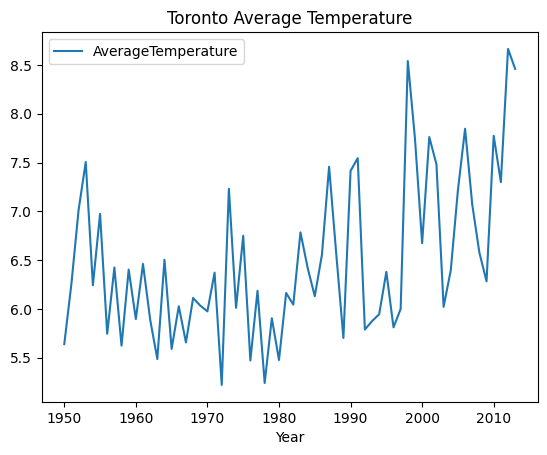

In [7]:
trunc_df.createOrReplaceTempView("temp") 
toronto_temp_data = spark.sql(
    """SELECT AVG(AverageTemperature) as AverageTemperature, 
    EXTRACT(year from `dt`) as Year
    FROM temp
    WHERE City=='Toronto'
    GROUP BY Year
    ORDER BY Year
"""
)
toronto_temp_data.show(10) 
toronto_temp_data.toPandas().set_index("Year").plot() 
plt.title("Toronto Average Temperature")

#### Задание 3.3 (2 балла)

Найдите город, для которого выборочная дисперсия температур на приведенных данных максимальна. 

In [8]:
max_var_city = trunc_df.groupby(trunc_df.City).agg(f.variance("AverageTemperature").alias("Var")).sort(f.desc("Var"))
print(f"The maximum temperature variance was observed in {max_var_city.first().City}.")

The maximum temperature variance was observed in Harbin.


#### Задание 3.4 (4 балла)

На одной оси постройте графики, отображающие:
1. Зависимость выборочной дисперсии температур от широты города (Latitude).
2. Зависимость средней температуры в январе 1975 года от широты города (Latitude).
3. Зависимость средней температуры в июле 1975 года от широты города (Latitude).

In [9]:
def formatting_latitude(latitude: str) -> float:
    if 'N' in latitude:
        return float(latitude.replace("N", ""))
    elif "S" in latitude:
        return -1 *float(latitude.replace("S", ""))
    else:
        raise ValueError(f"Latitude value is probably malformed: {latitude}")
    
latitude_UDF = f.udf(lambda x:formatting_latitude(x)) 

In [30]:
trunc_df = trunc_df.withColumn("Latitude", latitude_UDF(f.col("Latitude")))
trunc_df = trunc_df.withColumn("Latitude",f.col("Latitude").cast('double'))

In [32]:
jan_expr = "1975-01-(\d+)"
january_df = trunc_df.filter(trunc_df["dt"].rlike(jan_expr))

july_expr = "1975-07-(\d+)"
july_df = trunc_df.filter(trunc_df["dt"].rlike(july_expr))

In [31]:
latitude = trunc_df.groupby(trunc_df.City, trunc_df.Latitude).count().select(trunc_df.City, trunc_df.Latitude)
latitude.show(5)

+---------+--------+
|     City|Latitude|
+---------+--------+
|  Abidjan|    5.63|
|   Berlin|   52.24|
|Changchun|    44.2|
|   Bogotá|    4.02|
|     Cali|    4.02|
+---------+--------+
only showing top 5 rows



In [33]:
joined = max_var_city.join(latitude, ["City"])
joined = joined.select(joined.Var, joined.Latitude)
joined.show(5)

+-------------------+--------+
|                Var|Latitude|
+-------------------+--------+
| 1.8723871715723202|    5.63|
| 49.932927507043665|   52.24|
| 194.60047616720158|    44.2|
|0.39537088651678776|    4.02|
| 0.3961628177471861|    4.02|
+-------------------+--------+
only showing top 5 rows



In [34]:
january_df = january_df.select(january_df.AverageTemperature, january_df.Latitude)
january_df.show(5)

+------------------+--------+
|AverageTemperature|Latitude|
+------------------+--------+
|              26.5|    5.63|
|16.592000000000002|    8.84|
|            18.686|   23.31|
|5.5920000000000005|   36.17|
|            13.806|   31.35|
+------------------+--------+
only showing top 5 rows



In [36]:
july_df = july_df.select(july_df.AverageTemperature, july_df.Latitude)
july_df.show(5)

+------------------+--------+
|AverageTemperature|Latitude|
+------------------+--------+
|            24.647|    5.63|
|            16.456|    8.84|
|            28.713|   23.31|
|            29.414|   36.17|
|            25.774|   31.35|
+------------------+--------+
only showing top 5 rows



In [37]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.2, rc={"figure.figsize": (14, 8)})

In [39]:
type(joined_pandas.Latitude[0])

numpy.float64

In [38]:
joined_pandas = joined.toPandas()
july_df = july_df.toPandas()
january_df = january_df.toPandas()



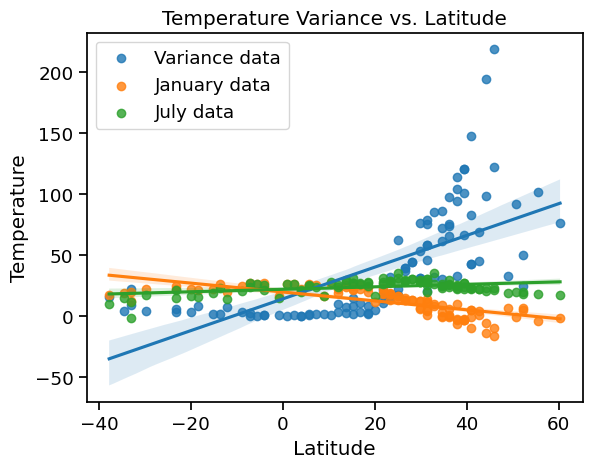

In [42]:
sns.regplot(x="Latitude", y="Var", data=joined_pandas, label="Variance data") 
sns.regplot(x="Latitude", y="AverageTemperature", data=january_df, label="January data" )
sns.regplot(x="Latitude", y="AverageTemperature", data=july_df, label="July data")

plt.legend()
plt.title("Temperature Variance vs. Latitude") 
plt.xlabel("Latitude") 
plt.ylabel("Temperature")

plt.show()